In [ ]:
#Same as GC_content_rw_plots.ipynb but uses promoters only not 5'UTR. (Araport11 TSS)

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats

In [67]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='promoters'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
GC_content_tsv = f'../../../data/output/{file_names}/rolling_window/GC_content_rw_promoterno5UTR/{promoter_pref}_GCcontent_rw.tsv'
EPD_TSS_bed = f'../../../data/EPD_promoter_analysis/EPDnew_promoters/At_EPDnew.bed'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'
promoter_no_5UTR = f'{location}/promoters.gff3'
foldername_prefix = 'GC_content_rw'

In [68]:
#bp covered chromatin files
root_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_promoterno5UTR/{promoter_pref}_root_bpcovered_rw.bed'
shoot_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_promoterno5UTR/{promoter_pref}_shoot_bpcovered_rw.bed'
rootshootintersect_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw_promoterno5UTR/{promoter_pref}_rootshootintersect_bpcovered_rw.bed'

In [69]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/OpenChromatin_rw_promoterno5UTR/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/OpenChromatin_rw_promoterno5UTR/plots  already exists


In [70]:
promoters = pd.read_csv(Czechowski_gene_categories, sep='\t', header=None)
cols = ['AGI','gene_type']
promoters.columns = cols
GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
GC_content
cols2 = ['name', 'percentage_GC_content']
GC_content.columns = cols2
#Make AGI column
GC_content['AGI'] = GC_content.name.str.split('_',expand=True)[0]
#make window number column
GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
#make chr column
GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
#make start column
GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
#make stop column
GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])
#make df columns integars
GC_content = GC_content.astype({'stop':'int','start':'int','chr':'int'})
#add window length column
GC_content = GC_content.assign(window_length=GC_content.stop - GC_content.start)

# #merge to limit to genes of interest
# GC_content = pd.merge(promoters, GC_content, how ='left', on='AGI')
# GC_content

In [71]:
GC_content

,name,percentage_GC_content,AGI,window_number,chr,start,stop,window_length
0,AT1G01010_19::1:2630-2730,38.0,AT1G01010,19,1,2630,2730,100
1,AT1G01010_18::1:2680-2780,37.0,AT1G01010,18,1,2680,2780,100
2,AT1G01010_17::1:2730-2830,34.0,AT1G01010,17,1,2730,2830,100
3,AT1G01010_16::1:2780-2880,37.0,AT1G01010,16,1,2780,2880,100
4,AT1G01010_15::1:2830-2930,39.0,AT1G01010,15,1,2830,2930,100
...,...,...,...,...,...,...,...,...
273722,AT5G67640_15::5:26971368-26971468,40.0,AT5G67640,15,5,26971368,26971468,100
273723,AT5G67640_16::5:26971418-26971518,40.0,AT5G67640,16,5,26971418,26971518,100
273724,AT5G67640_17::5:26971468-26971568,40.0,AT5G67640,17,5,26971468,26971568,100
273725,AT5G67640_18::5:26971518-26971618,40.0,AT5G67640,18,5,26971518,26971618,100


In [72]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("white")

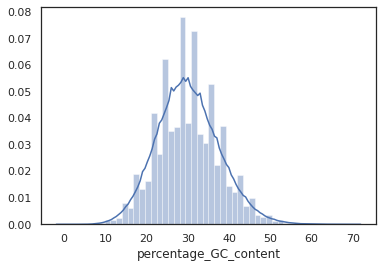

In [73]:
dist_plot = GC_content['percentage_GC_content']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

In [74]:
#remove windows with fewer than 100 promoters extending to that location
GC_content = GC_content[GC_content['window_number'].map(GC_content['window_number'].value_counts()) > 99]

In [75]:
def add_coverage(df,coverage_bed,suffix):
    """add % bp covered data from a bed file to the df. Prefix is a name added to any new columns"""
    #read in bed file
    coverage_df = pd.read_table(coverage_bed, sep='\t', header=None)
    cols = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
    coverage_df.columns = cols
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df['fraction_bases_covered'] * 100
    #filter columns
    coverage_df = coverage_df[['chr','start','stop','name','percentage_bases_covered']]
    #make df columns integars
    df = df.astype({'stop':'int','start':'int','chr':'int'})
    coverage_df = coverage_df.astype({'stop':'int','start':'int','chr':'int'})
    #merge the dfs
    merged = pd.merge(df,coverage_df, how='left',on=['chr','start','stop'],suffixes=('', f'_{suffix}'))
    #remove NaN
    #merged = merged[merged['name'].notnull()] 
    return merged

In [76]:
def windows_coords(output_prefix,variable_of_interest,variable_of_interest_name,variable_of_interest_df,promoter_bed,
                   window_offset,chromatin_tissue_variable='percentage_bases_covered_rootshootintersect_chrom',
                   chromatin_tissue_variable_name='% open chromatin root and shoot intersect',x_range=False,estimator='mean',ci=95, n_boot=1000, 
                   genetype=False, genetype2=False, genetype3=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot. Also add promoter length distributio, Araport TSS distribution,
    EPD TSS distribution (add the most common TSS as documented on eukaryotic promoter database Arabidopsis last modified on EPD 06/06/2018)"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start  
    #merge promoter_bed with variable_of_interest_df on AGI
    merged = pd.merge(variable_of_interest_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))
    #remove NaN
    merged = merged[merged[variable_of_interest].notnull()]
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add variable of interest position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    
    #calculate longest promoter length based on window cutoff
    number_of_windows = len(variable_of_interest_df.window_number.unique())
    window_length = variable_of_interest_df.window_length.max()    
    length_of_longest_promoter = number_of_windows*(window_length-window_offset)

    #make integars
    merged2 = merged2.astype({f'{variable_of_interest}':'float64',f'{chromatin_tissue_variable}':'float64'})

    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    merged2[['length','position']] = -merged2[['length','position']]
    #change estimator
    if estimator == 'mean':
        new_estimator=estimator
        
    if estimator == 'median':
        new_estimator = np.median
    #set number of subplots so can easily change all output possibilities, where subplotA is the top
    subplots = 2

    f, axes = plt.subplots(subplots, figsize=(10,8))
    OpenChromplot = axes[subplots-subplots]
    variableofinterestplot = axes[subplots-(subplots-1)]

   
    
    #check the plot axes variables are there. If they are not, assign None to them
    try:
        OpenChromplot
    except NameError:
        OpenChromplot = None

    try:
        variableofinterestplot
    except NameError:
        variableofinterestplot = None
    

    if genetype==False:
        

        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:
            #Open chromatin lineplot
            sns.lineplot(y=merged2[chromatin_tissue_variable],x=merged2.position,ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'All promoters {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])  

        
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest], x=merged2.position, ax=variableofinterestplot,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'All promoters sliding windows {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of Araport 11 TSS')

               
    elif genetype2==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:        
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'{genetype} {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([]) 
            


        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position,
                         ax=variableofinterestplot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'{genetype} {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of Araport 11 TSS')
        

    elif genetype3==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            #set titles & axes names
            OpenChromplot.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])

        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterestplot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterestplot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterestplot.set_title(f'{variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of Araport 11 TSS')
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2]
        # Create the legend
        axes[0].legend()

    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype3][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype3].position,
                         ax=OpenChromplot,estimator=new_estimator,label=genetype3,ci=ci, n_boot=n_boot)
            #set titles & axes names 
            OpenChromplot.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])          
    
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, 
                            ax=variableofinterestplot, label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position, 
                            ax=variableofinterestplot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest], x=merged2[merged2.gene_type == genetype3].position, 
                            ax=variableofinterestplot,label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterestplot.set_title(f'{variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of Araport 11 TSS')
        #gene_type labels
        gene_type_labels = [genetype, genetype2, genetype3]
        # Create the legend
        axes[0].legend()
    #set x axis range if specified    
    if x_range==False:
        pass
    else:
        length_of_longest_promoter = x_range
        
    #for all subplots:
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim([-length_of_longest_promoter,0])
    #use a tight layout
    f.tight_layout()
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/{foldername_prefix}_promoterno5UTR/plots/{output_prefix}_{estimator}_openchromatin_sliding_window.pdf', format='pdf')    
    return merged2

In [77]:
def plot_length(df, genetype=False, genetype2=False, genetype3=False):
    """function to plot length distribution of promoter"""
    #make lengths positive by squaring and then square rooting
    df.length = (df.length**2)**(1/2)

    if genetype==False:
        dist_plot = df['length']
        #create figure with no transparency
        dist_plot_fig = sns.distplot(dist_plot).get_figure()

    elif genetype2==False:
        sns.distplot(df[df.gene_type == genetype].length, label=genetype)
        
    elif genetype3==False:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2).get_figure()
        plt.legend()
    else:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].length,hist=None,label=genetype3)
        plt.legend()
        
        

In [78]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""

    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [79]:
GC_content.columns

Index(['name', 'percentage_GC_content', 'AGI', 'window_number', 'chr', 'start',
       'stop', 'window_length'],
      dtype='object')

In [80]:
#add root chromatin coverage data
GC_content = add_coverage(GC_content, root_chrom_bp_covered,'root_chrom')
#add shoot chromatin coverage data
GC_content = add_coverage(GC_content, shoot_chrom_bp_covered,'shoot_chrom')
#add rootshootintersect chromatin coverage data
GC_content = add_coverage(GC_content, rootshootintersect_chrom_bp_covered,'rootshootintersect_chrom')

In [81]:
GC_content

,name,percentage_GC_content,AGI,window_number,chr,start,stop,window_length,name_root_chrom,percentage_bases_covered,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,AT1G01010_19::1:2630-2730,38.0,AT1G01010,19,1,2630,2730,100,AT1G01010_19,100.0,AT1G01010_19,100.0,AT1G01010_19,100.0
1,AT1G01010_18::1:2680-2780,37.0,AT1G01010,18,1,2680,2780,100,AT1G01010_18,100.0,AT1G01010_18,100.0,AT1G01010_18,100.0
2,AT1G01010_17::1:2730-2830,34.0,AT1G01010,17,1,2730,2830,100,AT1G01010_17,100.0,AT1G01010_17,100.0,AT1G01010_17,100.0
3,AT1G01010_16::1:2780-2880,37.0,AT1G01010,16,1,2780,2880,100,AT1G01010_16,100.0,AT1G01010_16,100.0,AT1G01010_16,100.0
4,AT1G01010_15::1:2830-2930,39.0,AT1G01010,15,1,2830,2930,100,AT1G01010_15,100.0,AT1G01010_15,97.0,AT1G01010_15,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277558,AT5G67640_15::5:26971368-26971468,40.0,AT5G67640,15,5,26971368,26971468,100,AT5G67640_15,24.0,AT5G67640_15,0.0,AT5G67640_15,0.0
277559,AT5G67640_16::5:26971418-26971518,40.0,AT5G67640,16,5,26971418,26971518,100,AT5G67640_16,0.0,AT5G67640_16,0.0,AT5G67640_16,0.0
277560,AT5G67640_17::5:26971468-26971568,40.0,AT5G67640,17,5,26971468,26971568,100,AT5G67640_17,0.0,AT5G67640_17,0.0,AT5G67640_17,0.0
277561,AT5G67640_18::5:26971518-26971618,40.0,AT5G67640,18,5,26971518,26971618,100,AT5G67640_18,0.0,AT5G67640_18,0.0,AT5G67640_18,0.0


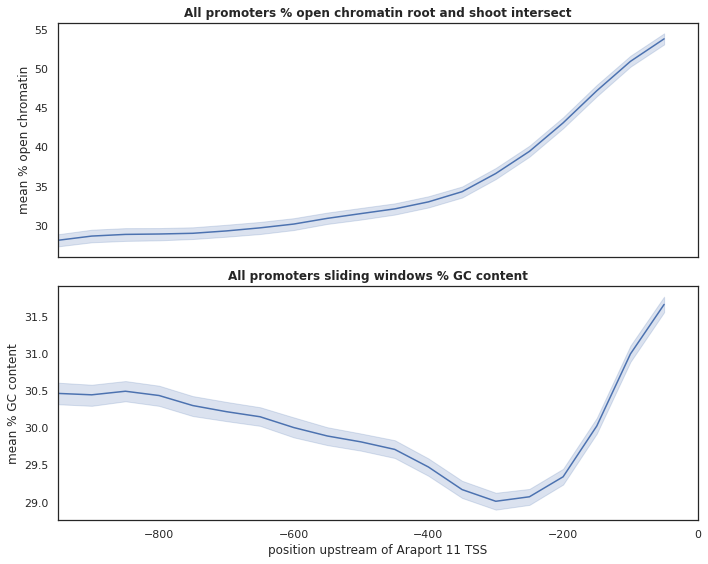

In [82]:
#all promoters in genome
all_proms = windows_coords('all_proms','percentage_GC_content','% GC content',GC_content,promoter_bed,50)

## Now do constitutive and variable promoter from Czechowski et al 2005

In [83]:
GC_prom_types = add_genetype(GC_content, Czechowski_gene_categories)

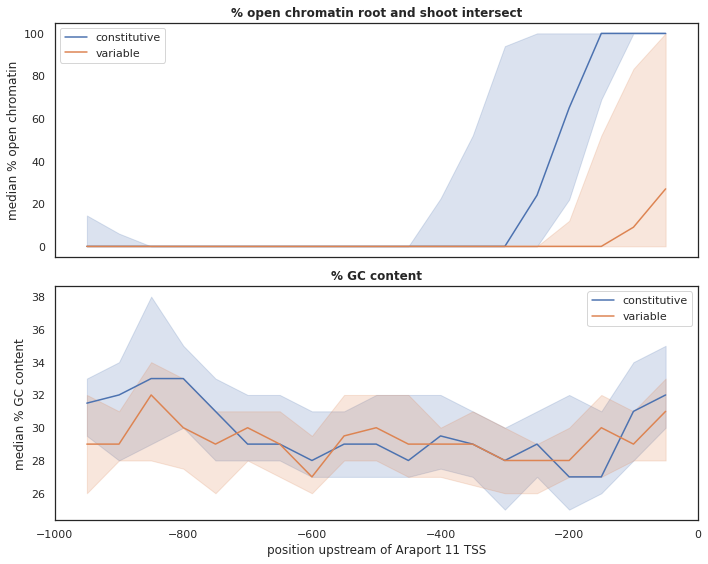

In [91]:
rolling_rootshootintersect = windows_coords('openchrom_GCcontent_promotersno5UTR_Czechowskigenetypesnocontrol','percentage_GC_content','% GC content',GC_prom_types,promoter_bed,
                         50,x_range=1000,estimator='median',ci=95, n_boot=10000,  genetype='constitutive', genetype2='variable')

In [85]:
GC_prom_types

,AGI,gene_type,name,percentage_GC_content,window_number,chr,start,stop,window_length,name_root_chrom,percentage_bases_covered,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,AT4G34270,constitutive,AT4G34270_1::4:16406303-16406403,29.0,1,4.0,16406303.0,16406403.0,100.0,AT4G34270_1,100.0,AT4G34270_1,100.0,AT4G34270_1,100.0
1,AT4G34270,constitutive,AT4G34270_2::4:16406353-16406453,26.0,2,4.0,16406353.0,16406453.0,100.0,AT4G34270_2,100.0,AT4G34270_2,100.0,AT4G34270_2,100.0
2,AT4G34270,constitutive,AT4G34270_3::4:16406403-16406503,39.0,3,4.0,16406403.0,16406503.0,100.0,AT4G34270_3,100.0,AT4G34270_3,100.0,AT4G34270_3,100.0
3,AT4G34270,constitutive,AT4G34270_4::4:16406453-16406553,41.0,4,4.0,16406453.0,16406553.0,100.0,AT4G34270_4,100.0,AT4G34270_4,100.0,AT4G34270_4,100.0
4,AT4G34270,constitutive,AT4G34270_5::4:16406503-16406603,30.0,5,4.0,16406503.0,16406603.0,100.0,AT4G34270_5,100.0,AT4G34270_5,100.0,AT4G34270_5,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,AT4G39950,control,AT4G39950_5::4:18524741-18524841,27.0,5,4.0,18524741.0,18524841.0,100.0,AT4G39950_5,79.0,AT4G39950_5,0.0,AT4G39950_5,0.0
3931,AT4G39950,control,AT4G39950_4::4:18524791-18524891,32.0,4,4.0,18524791.0,18524891.0,100.0,AT4G39950_4,100.0,AT4G39950_4,12.0,AT4G39950_4,12.0
3932,AT4G39950,control,AT4G39950_3::4:18524841-18524941,34.0,3,4.0,18524841.0,18524941.0,100.0,AT4G39950_3,100.0,AT4G39950_3,62.0,AT4G39950_3,62.0
3933,AT4G39950,control,AT4G39950_2::4:18524891-18524991,35.0,2,4.0,18524891.0,18524991.0,100.0,AT4G39950_2,100.0,AT4G39950_2,100.0,AT4G39950_2,100.0


In [86]:
GC_prom_types_length = add_genetype(all_proms, Czechowski_gene_categories)

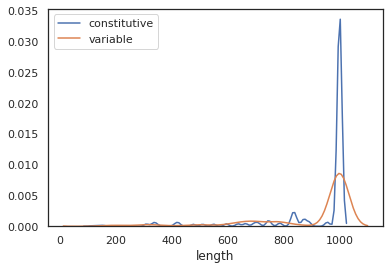

In [87]:
plot_length(GC_prom_types_length, genetype='constitutive', genetype2='variable')

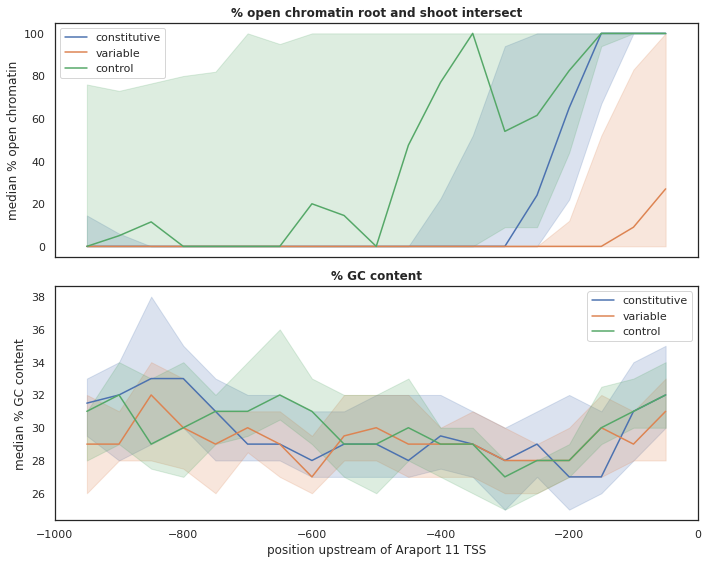

In [93]:
rolling_incl_control = windows_coords('openchrom_GCcontent_promotersno5UTR_Czechowski_genetypes','percentage_GC_content','% GC content',GC_prom_types,
                                      promoter_bed, 50,estimator='median',ci=95, n_boot=10000,x_range=1000,
                                      genetype='constitutive', genetype2='variable', genetype3='control')

In [ ]:
plot_length(GC_prom_types_length, genetype='constitutive', genetype2='variable', genetype3='control')